In [96]:
'''Helpful References:
Segmentation with Coins: http://scikit-image.org/docs/dev/user_guide/tutorial_segmentation.html
Watershed: http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html
Region-Prop: http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_regionprops.html
'''

'Helpful References:\nSegmentation with Coins: http://scikit-image.org/docs/dev/user_guide/tutorial_segmentation.html\nWatershed: http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html\nRegion-Prop: http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_regionprops.html\n'

In [97]:
import numpy as np
from skimage.morphology import skeletonize, medial_axis, watershed
from skimage import data
from scipy import ndimage as ndi
from scipy.spatial import distance
import matplotlib.pyplot as plt
from skimage.util import invert
from skimage.io import imshow, imread
from skimage.color import rgb2gray
from skimage.feature import peak_local_max, canny
from scipy import ndimage
from skimage.filters import sobel
from skimage.measure import label, regionprops

Original Image


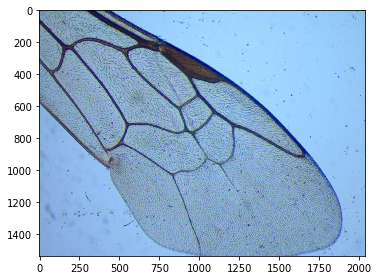

In [98]:
bee_image = imread("raw_image/2.jpg")
imshow(bee_image)
print("Original Image")

Black and White Image


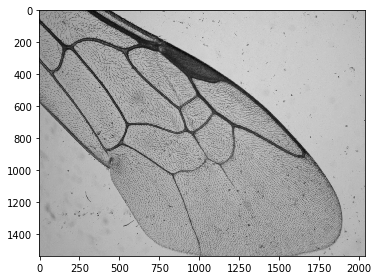

In [99]:
bnw = rgb2gray(bee_image)
imshow(bnw)
print("Black and White Image")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


Markers


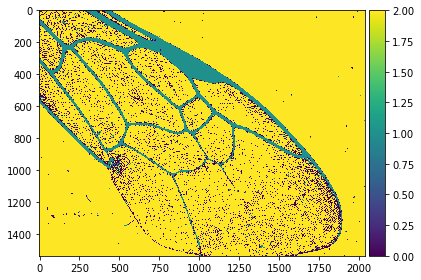

In [100]:
markers = np.zeros_like(bnw)
markers[bnw < 0.45] = 1
markers[bnw > 0.55] = 2
imshow(markers)
print("Markers")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


Segmented Image Using Watershed


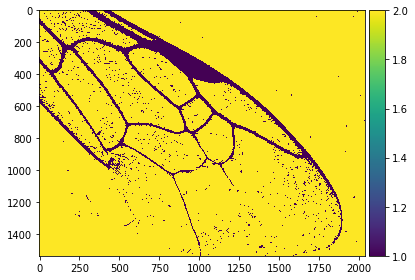

In [101]:
elevation_map = sobel(bnw)
segmentation = watershed(elevation_map, markers)
imshow(segmentation)
print("Segmented Image Using Watershed")

Watershed, Binary


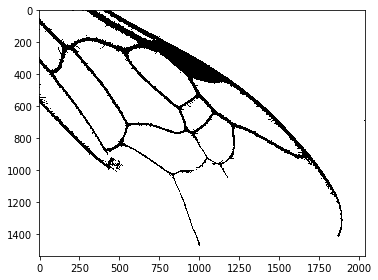

In [102]:
segmentation = ndi.binary_fill_holes(segmentation - 1)
imshow(segmentation)
print("Watershed, Binary")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


Labeled Regions


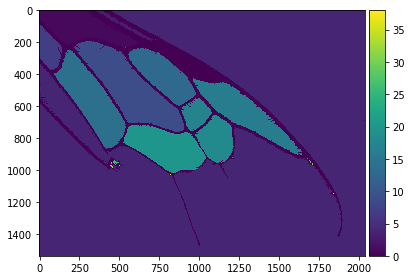

In [103]:
labeled_wing, _ = ndi.label(segmentation)
imshow(labeled_wing)
print("Labeled Regions")

Number of Regions:  38
Filtered Regions:  10


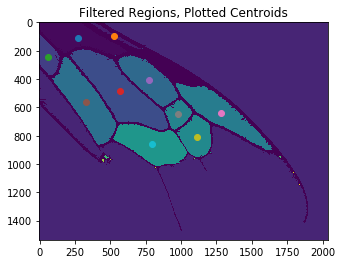

In [104]:
regions = regionprops(labeled_wing)
print("Number of Regions: ", len(regions))
implot = plt.imshow(labeled_wing)

#Filters regions based on area
filtered_regions = []
filtered_regions_area = []
for props in regions:
    area = props.area
#     print([500, 600] in props.coords)
    if area>1000 and area<400000:
        filtered_regions.append(props)
        filtered_regions_area.append(area)
print("Filtered Regions: ", len(filtered_regions))

#Plots centroids of regions
for region in filtered_regions:
    y0, x0 = region.centroid
    plt.scatter([x0], [y0])
plt.title("Filtered Regions, Plotted Centroids")
plt.show()

Center of Regions: 


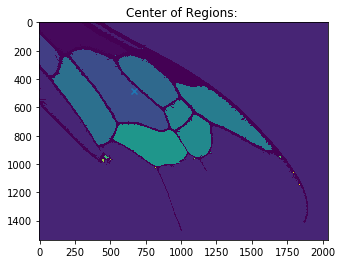

In [105]:
#Finds the centroid of all the region centers
# sum_x, sum_y = 0, 0
centroids = []
centroids_x = []
centroids_y = []
for region in filtered_regions:
    y0, x0 = region.centroid
    region_centroid = (x0, y0)
    centroids.append(region_centroid)
    centroids_x.append(x0)
    centroids_y.append(y0)
#     sum_x += x0
#     sum_y += y0
# avg_x = sum_x/len(filtered_regions)
# avg_y = sum_y/len(filtered_regions)
avg_x = np.mean(centroids_x)
avg_y = np.mean(centroids_y)

print("Center of Regions: ")
implot = plt.imshow(labeled_wing)
plt.scatter([avg_x], [avg_y], marker="x")
plt.title("Center of Regions: ")
plt.show()

In [106]:
#Calculates the distance between each centroid to the center
# implot = plt.imshow(labeled_wing)
distances_from_center = []
for centroid in centroids:
    distances_from_center.append(distance.euclidean(centroid, (avg_x, avg_y)))
# min_dist_centroid = centroids[distances_from_center.index(min(distances_from_center))]
# plt.scatter([min_dist_centroid[0]], [min_dist_centroid[1]])

#Normalizes distances from center using sd and mean
distance_sd = np.std(distances_from_center)
distance_mean = np.mean(distances_from_center)
# print("Distance Average", distance_mean, "Distance Standard Dev", distance_sd)
dist_from_cent_norm = [dist_from_center/distance_mean for dist_from_center in distances_from_center]
print("Distance, Scaled: \n", dist_from_cent_norm)

#Normalizes areas using sd and mean
area_sd = np.std(filtered_regions_area)
area_mean = np.mean(filtered_regions_area)
area_norm = [area/area_mean for area in filtered_regions_area ]
print("Area, Scaled: \n", area_norm)

Distance, Scaled: 
 [1.3327650001153026, 1.01275036816543, 1.5825034847360515, 0.25110811921457121, 0.31927023215036698, 0.84598581981300947, 1.5290373341888301, 0.85224782370885288, 1.3206365457744618, 0.95369527213312411]
Area, Scaled: 
 [1.0830974401183453, 0.1019809468725843, 0.36603304544165327, 2.1394031577249697, 1.0334208316417612, 1.5889284979395262, 1.3394470922569559, 0.33939425959190939, 0.6682497928403397, 1.3400449355719553]


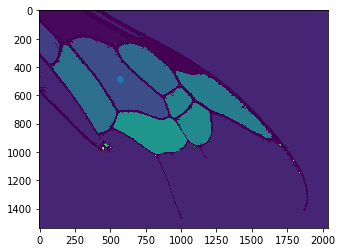

In [107]:
#Weights each region centroid based on distance to the center, and size
implot = plt.imshow(labeled_wing)
distance_weight = 1
size_weight = 1

weighted_values = []
for i in range(len(filtered_regions)):
    weighted_values.append(size_weight*area_norm[i] - distance_weight*dist_from_cent_norm[i])

max_index = weighted_values.index(max(weighted_values))
center_cell = filtered_regions[max_index]
# plt.scatter([centroids[max_index][0]], [centroids[max_index][1]])
center_cell_x, center_cell_y = center_cell.centroid[1], center_cell.centroid[0]
plt.scatter([center_cell_x], [center_cell_y])

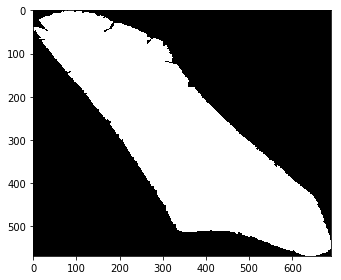

In [114]:
imshow(center_cell.image)

In [108]:
# distance = ndi.distance_transform_edt(bnw)
# local_maxi = peak_local_max(distance)
# markers = ndi.label(local_maxi)
# labels = watershed(-distance, markers, mask=bnw)

# imshow(-distance)

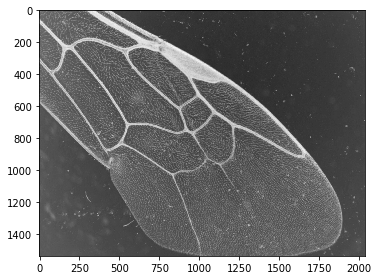

In [109]:
inverted_bee_image = invert(bnw)
imshow(inverted_bee_image)

In [110]:
# skeleton = medial_axis(bnw)
# fig, axes = plot.subplots(nrows=1, ncols=2, figsize=(8, 4),
#                          sharex=True, sharey=True)
# ax = axes.ravel()
# ax[0].imshow(skeleton, cmap=plot.cm.gray)
# imshow(skeleton)
# distance = ndimage.distance_transform_edt(bnw)
# local_maxi = peak_local_max(
#     distance, indices=False, footprint=np.ones((3, 3)), labels=bnw)
# markers = ndimage.label(local_maxi)[0]
# labels = watershed(-distance, markers, mask=image)

In [111]:
# distance = ndi.distance_transform_edt(bnw)